In [87]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import least_squares
import pandas as pd
import re
from tqdm import tqdm
from mpl_toolkits import mplot3d

Let's find the beginning date $t_0$ which $V(t_0) > V_{min}$ ($V_{min} = 5$) and do some preprocessing here.

In [88]:
df = pd.read_csv('Validation.csv')

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")

# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

54
2020-03-16


In [89]:
# Get population
population = df["Population"][0]
# Get the V(t): detected infection 
accumulated_cases = np.array(df_clean.iloc[0])
# Get the Y(t): the cumulative number of deaths
accumulated_deaths = np.array(df_clean.iloc[1])

T_max = 40
I = np.zeros(T_max + 1)

# Get the I(t)
for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 - 7]


# Get the I(t)
I_all = np.zeros(120)
for t in range(0, 120):
    I_all[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 - 7]

# When accumulated_deaths > 5, the simulation starts
# t_deaths_0 = np.argwhere(accumulated_deaths > 5)[1, 0]
accumulated_deaths = accumulated_deaths[t0:]

# Exercise 1

 This problem asks you to implement and run the Meta-Algorithm for SIR Calibration using the time series of cumulative number of detected infection $V(t)$ and the cumulative number of deaths $Y(t)$. Use initialization $S(0) = N$, $I(0)$ from the data set, $R(0) = 0$. Use the following parameters: $T_{max} = 119$ (i.e., a total of 120 time samples), $V_{min} = 5, \tau_0 = 7, p = 1, 2, ∞ $(check all three values), $\lambda = 1$. For the set $\Omega$ write nested loops over $\alpha$, $R_0$, and $N$ by searching over the following intervals: $\alpha$ ∈ [0.05, 0.2], $R_0$ ∈ [1.5, 1.9], $N / Population ∈$ [2%, 10%]. 
 
 Recall $\beta = R_0\alpha$, and $P$ opulation is extracted from your data set.

The first step is to generate a set of potential simulation params. In this case, we sampled 10 for each of the 3 parameters. We then generated a set of 1000 simulations using these parameters.

In [90]:
# Exercise 1

omegas = []
for alpha in np.linspace(0.05, 0.2, 10):
    for r0 in np.linspace(1.5, 1.9, 10):
        beta = alpha * r0
        for p in np.linspace(0.02, 0.1, 10):
            omegas.append((alpha, beta, r0, p * population))

print(f"Number of simulations: {len(omegas)}")

Number of simulations: 1000


Then, let's implement the SIR model following our PPT. We also need to implement an ode solver. We will use the Euler method here.

In [91]:
def SIR_simulation(x, T_max):
    # S, I, R
    alpha, beta, N = x
    y_0 = [N-I[0], I[0], 0]  # Susceptible, Infected, Recovered
    T = 0.01

    results = [
        y_0,
    ]

    # Euler method
    for t in np.arange(start=1, stop=T_max+1, step=0.01):
        y_0 = [
            y_0[0] - beta * y_0[0] * y_0[1]/N * T,
            y_0[1] + beta * y_0[0] * y_0[1]/N * T- alpha * y_0[1] * T,
            y_0[2] + alpha * y_0[1] * T
        ]
        results.append(y_0)
    
    results = np.array(results)
    results = results[::100]

    return results[:, 0], results[:, 1], results[:, 2]

## Question (1)
Find and print the minimum of the objective function $J$. Print the optimal values of $\hat{\alpha}$, $\hat{\beta}$, $\hat{R_0}$, $\hat{N}$ and $\hat{\gamma}$ ($\hat{\gamma}$ is obtained by implementing the minimization of ${\lvert |Y − \gamma R_{sim}| \rvert}_p$ over $\gamma$).

## Question (2) 
Visualize the 2D surface (function) $(α, β) \rightarrow J = J(\alpha, \beta, \hat{N}, \hat{\gamma})$ at the optimal values $\hat{N}$ and $\hat{\gamma}$ obtained before. You should obtain one plot for each $p$.


## Question (3) 
Plot on the same graph the simulated $I_{sim}$ and the preprocessed rate of detected infections $I(t) = V (t + t_0 + \tau_0) − V (t + t_0 − \tau_0)$. Plot on the same graph the predicted number of deaths $Y_{sim} = \hat{\gamma}R_{sim}$ and the observed number of deaths $Y(t)$ from your data set. You should obtain two plots for each value of $p$.

We run $SIR$ simulations for all questions (Sub question 1 to 3).

In [92]:
def get_gamma(V, p):
    if p == 2:
        up = np.sum(accumulated_deaths[7:T_max+1] * V[:T_max-7+1])
        down = np.sum(np.abs(V[:T_max-7+1]) ** 2)

        gamma = up / down

        return max(0, min(1, gamma))

    if p == 1:
        minimum_gamma = None

        for k in range(0, T_max - 7 + 1):
            r_k = accumulated_deaths[k + 7] / V[k]

            if not (0 <= r_k <= 1):
                continue
            
            f = np.sum(np.abs(accumulated_deaths[7:T_max+1] - r_k * V[:T_max-7+1]))
            if minimum_gamma is None or f < minimum_gamma[0]:
                minimum_gamma = (f, r_k)

        return minimum_gamma[1]

    if p == np.inf:
        A = np.zeros((2*(T_max - 7 + 1), 2))
        b = np.zeros(2*(T_max - 7 + 1))

        for k in range(0, T_max - 7 + 1):
            A[2*k, 0] = -1
            A[2*k, 1] = -V[k]
            A[2*k+1, 0] = -1
            A[2*k+1, 1] = V[k]

            b[2*k] = -accumulated_deaths[k + 7]
            b[2*k+1] = accumulated_deaths[k + 7]
        
        return np.linalg.lstsq(A, b, rcond=None)[0][1]

100%|██████████| 1000/1000 [00:06<00:00, 148.98it/s]


[p=1] alpha: 0.16666666666666669, beta: 0.3166666666666667, r0: 1.9, N: 14114.98, gamma: 0.015387427744634377, J: 6795.9857280614815
Time when I_sim is lower than 5: T=104


<Figure size 640x480 with 0 Axes>

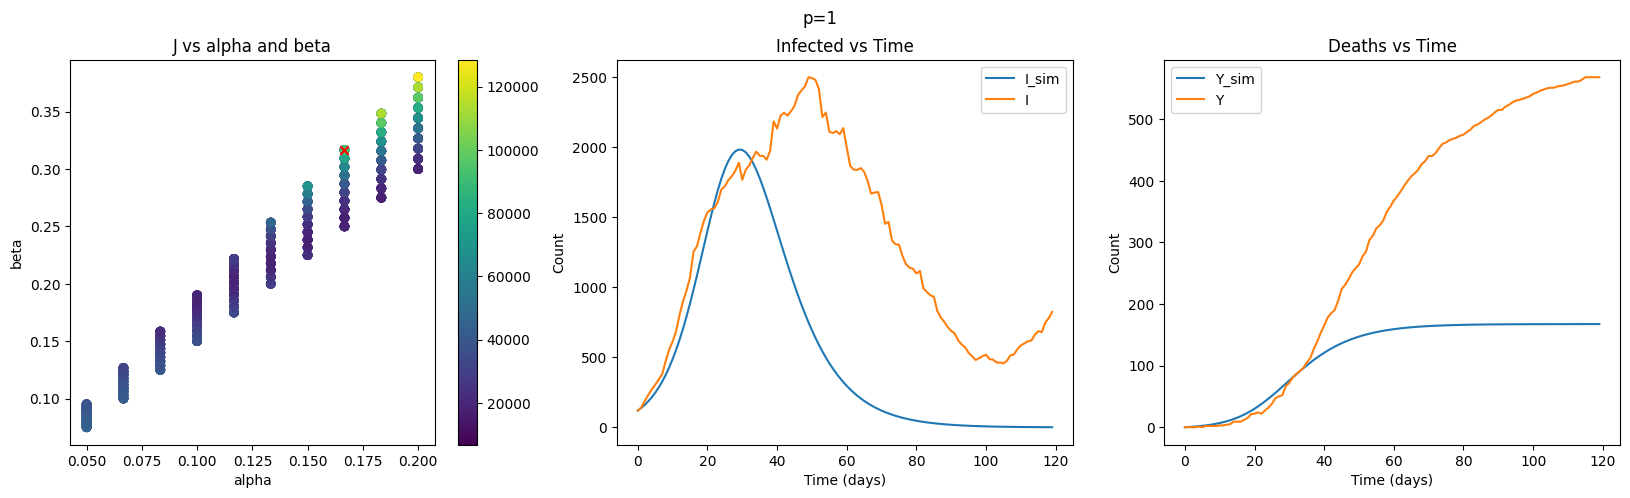

100%|██████████| 1000/1000 [00:06<00:00, 150.96it/s]


[p=2] alpha: 0.2, beta: 0.3355555555555556, r0: 1.6777777777777778, N: 20388.304444444442, gamma: 0.014579297366635132, J: 1772121.1828532126
Time when I_sim is lower than 5: T=108


<Figure size 640x480 with 0 Axes>

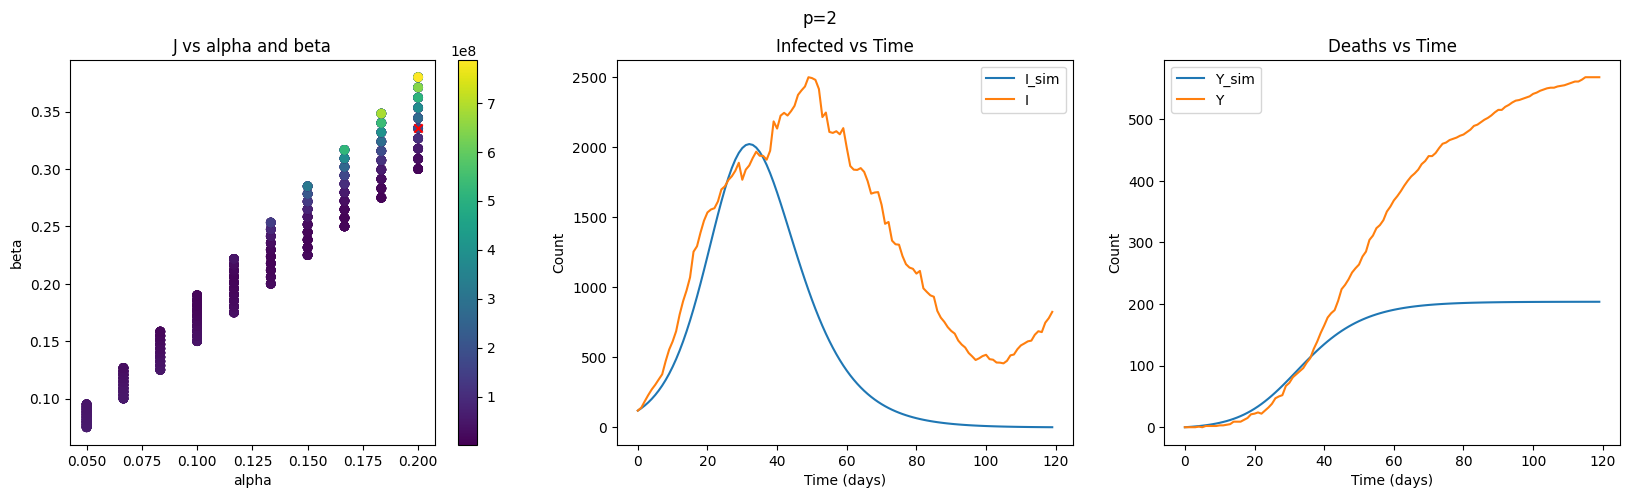

100%|██████████| 1000/1000 [00:06<00:00, 150.99it/s]


[p=inf] alpha: 0.15000000000000002, beta: 0.28500000000000003, r0: 1.9, N: 14114.98, gamma: 0.019855165266325706, J: 454.4536432665343
Time when I_sim is lower than 5: T=116


<Figure size 640x480 with 0 Axes>

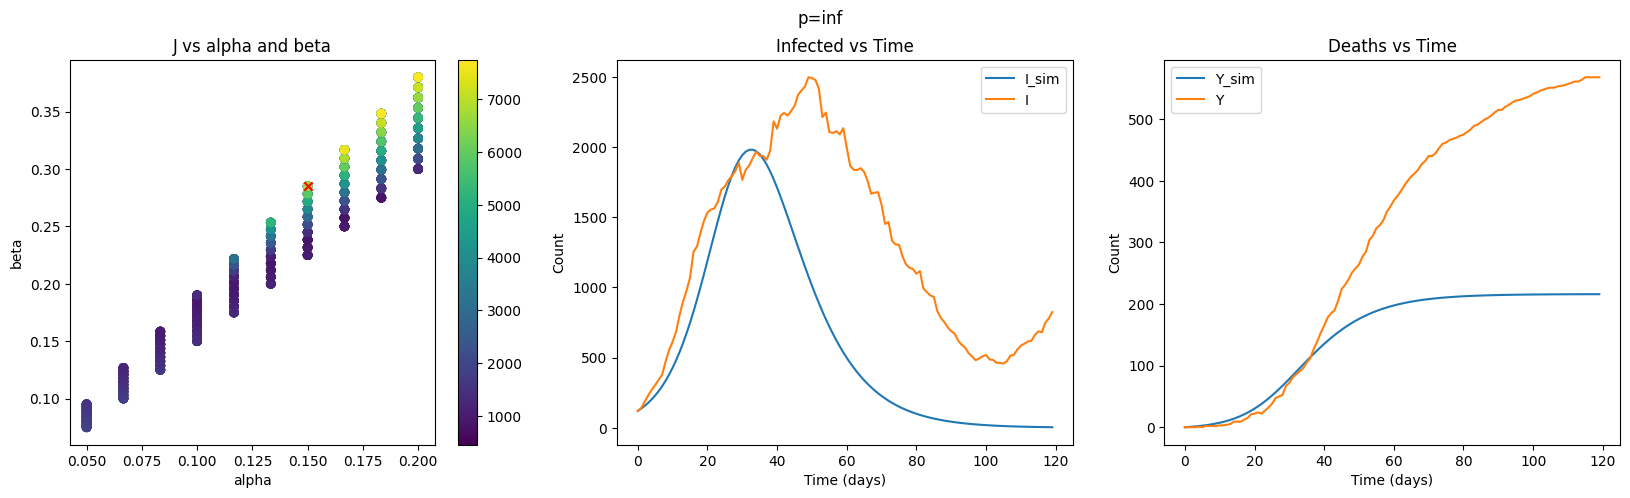

In [93]:
ps = [1, 2, np.inf]

for p in ps:
    lambda_ = 1
    minimum = None
    all_results = []

    for alpha, beta, r0, N in tqdm(omegas):
        S_sim, I_sim, R_sim = SIR_simulation((alpha, beta, N), T_max)

        gamma = get_gamma(R_sim[7:], p)

        if p != np.inf:
            J = np.sum(np.abs(I - I_sim) ** p) + lambda_ * np.sum(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim) ** p)
        else:
            J = np.max(np.abs(I - I_sim)) + lambda_ * np.max(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim))
            
        if minimum is None or J < minimum[0]:
            minimum = (J, alpha, beta, r0, N, gamma)
        
        all_results.append((J, alpha, beta, r0, N, gamma))

    J, alpha, beta, r0, N, gamma = minimum
    all_results = np.array(all_results)

    print(f"[p={p}] alpha: {alpha}, beta: {beta}, r0: {r0}, N: {N}, gamma: {gamma}, J: {J}")

    # Sub Question (2)
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"p={p}")

    temp = ax1.scatter(all_results[:, 1], all_results[:, 2], c=all_results[:, 0])
    ax1.scatter(alpha, beta, c="red", marker="x")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("beta")
    ax1.set_title("J vs alpha and beta")
    fig.colorbar(temp, ax=ax1)

    # Sub Question (3)
    S_sim, I_sim, R_sim = SIR_simulation((alpha, beta, N), 119)

    # Find when I_sim is lower than 5
    _, I_sim_long, _ = SIR_simulation((alpha, beta, N), 1000)
    pos = np.where(I_sim_long < 5)[0][0]
    print(f"Time when I_sim is lower than 5: T={pos}")

    ax2.plot(I_sim, label="I_sim")
    ax2.plot(I_all, label="I")
    ax2.legend()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Count")
    ax2.set_title("Infected vs Time")

    ax3.plot(gamma * R_sim, label="Y_sim")
    ax3.plot(accumulated_deaths[:120], label="Y")
    ax3.legend()
    ax3.set_xlabel("Time (days)")
    ax3.set_ylabel("Count")
    ax3.set_title("Deaths vs Time")

    plt.show()
    

## Question (4)
If you are asked to improve the estimates, what would be your refined range of parameters?

The above data shows that the expected $\alpha$ is 0.0666 ($1/15$), while the expected $\beta$ is between 0.10 to 0.11.

Since the above graphs look good, we probably rerun the experiments with $\alpha \in [0.05, 0.075]$ and $R_0 \in [1.4, 1.6]$.

# Exercise 2

This problem asks you to implement and run the Meta-Algorithm for $SEIR$ Calibration using the time series of cumulative number of detected infection $V(t)$ and the cumulative number of deaths $Y(t)$.

Use the same parameters as in Problem 1 with the following initialization: $S(0) = N$, $E(0) = I(0)$ to match the data set value $V(t_0 + τ_0) − V(t_0 − τ_0)$, $R(0) = 0$. For the set $\Omega$ write nested loops over $\alpha$, $R_0$, and $N$ by searching over the following intervals: $\alpha$ ∈ [0.05, 0.4], $\delta$ ∈ [0.05, 0.4], $R_0$ ∈ [1.5, 1.9], $N / Population$ ∈ [2%, 10%].

Recall $\beta = R_0\alpha$, and $P$ opulation is extracted from your data set.



The first step is to generate a set of potential simulation params. In this case, we sampled 7 for each of the 4 parameters. We then generated a set of 2401 simulations using these parameters. 

In [94]:
## Similar to 1

omegas = []
for alpha in np.linspace(0.05, 0.4, 7):
    for delta in np.linspace(0.05, 0.4, 7):
        for r0 in np.linspace(1.5, 1.9, 7):
            beta = alpha * r0
            for p in np.linspace(0.02, 0.1, 7):
                omegas.append((alpha, beta, delta, r0, p * population))

print(f"Number of simulations: {len(omegas)}")

Number of simulations: 2401


Then, let's implement the SEIR model following our PPT. We also need to implement an ode solver. We will use the Euler method here.

In [95]:
def SEIR_simulation(x, T_max):
    # S, E, I, R
    alpha, beta, delta, N = x
    y_0 = [N-2*I[0], I[0], I[0], 0]  # Susceptible, Exposed, Infected, Recovered
    T = 0.01

    results = [
        y_0,
    ]

    # Euler method
    for t in np.arange(start=1, stop=T_max+1, step=0.01):
        y_0 = [
            y_0[0] - beta * y_0[0] * y_0[2]/N * T,
            y_0[1] + beta * y_0[0] * y_0[2]/N * T - delta * y_0[1] * T,
            y_0[2] + delta * y_0[1] * T - alpha * y_0[2] * T,
            y_0[3] + alpha * y_0[2] * T
        ]
        results.append(y_0)
    
    results = np.array(results)
    results = results[::100]

    return results[:, 0], results[:, 1], results[:, 2], results[:, 3]


## Question (1)
Find and print the minimum of the objective function $J$. Print the optimal values of $\hat\alpha$, $\hat\beta$, $\hat\delta$, $\hat{R_0}$, $\hat{N}$ and $\hat\gamma$ ($\hat\gamma$ is obtained by implementing the minimization of ${\lvert |Y − \gamma R_{sim}| \rvert}_p$ over $\gamma$).

## Question (2) 
Visualize the 2D surfaces (functions):

• $(\alpha, \beta) \rightarrow J = J(\alpha, \beta, \hat\delta, \hat{N}, \hat\gamma)$ at the optimal values $\hat\delta$, $\hat{N}$ and $\hat\gamma$ obtained before. You should obtain one plot for each $p$.

• $(\alpha, \delta) \rightarrow J = J(\alpha, \hat\beta, \delta, \hat{N}, \hat\gamma)$ at the optimal values $\hat\beta$, $\hat{N}$ and $\hat\gamma$ obtained before. You should obtain one plot for each $p$.

• $(\beta, \delta) \rightarrow J = J(\hat\alpha, \beta, \delta, \hat{N}, \hat\gamma)$ at the optimal values $\hat\alpha$, $\hat{N}$ and $\hat\gamma$ obtained before. You should obtain one plot for each $p$.

## Question (3)
Plot on the same graph the simulated $I_{sim}$ and the preprocessed rate of detected infections $I(t) = V(t + t_0 + \tau_0) − V(t + t_0 − \tau_0)$ Plot on the same graph the predicted number of deaths $Y_{sim} = {\hat\gamma}R_{sim}$ and the observed number of deaths $Y(t)$ from your data set. You should obtain two plots for each value of $p$.

We run $SEIR$ simulations for all questions (Subquestion 1 to 3).

100%|██████████| 2401/2401 [00:20<00:00, 118.08it/s]

[p=1] alpha: 0.4, beta: 0.7333333333333334, delta: 0.4, r0: 1.8333333333333333, N: 32934.95333333334, gamma: 0.006773032678975444, J: 8253.757881379923


<Figure size 640x480 with 0 Axes>

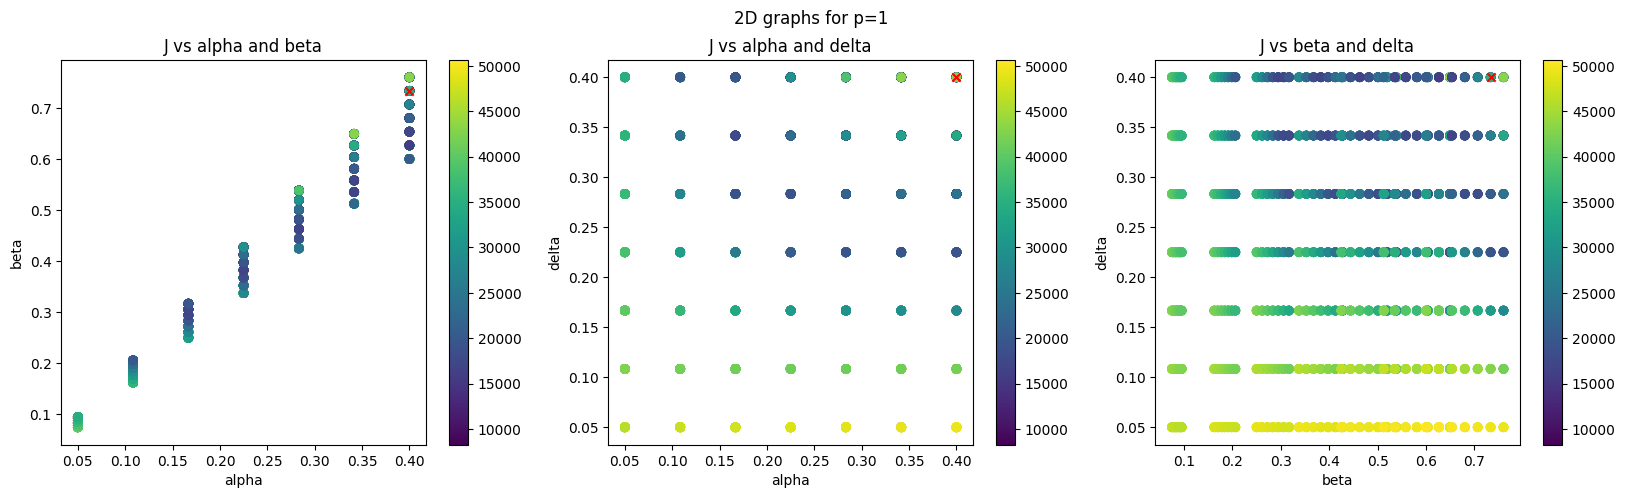

Time when I_sim is lower than 5: T=89


<Figure size 640x480 with 0 Axes>

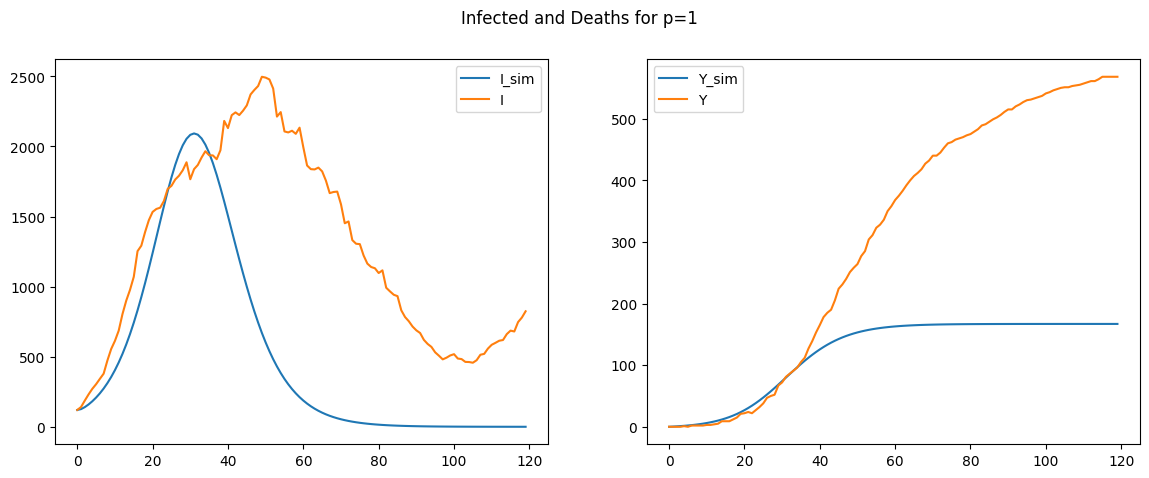

100%|██████████| 2401/2401 [00:19<00:00, 121.73it/s]


[p=2] alpha: 0.4, beta: 0.7333333333333334, delta: 0.4, r0: 1.8333333333333333, N: 32934.95333333334, gamma: 0.00723405654667306, J: 2438137.9286796325


<Figure size 640x480 with 0 Axes>

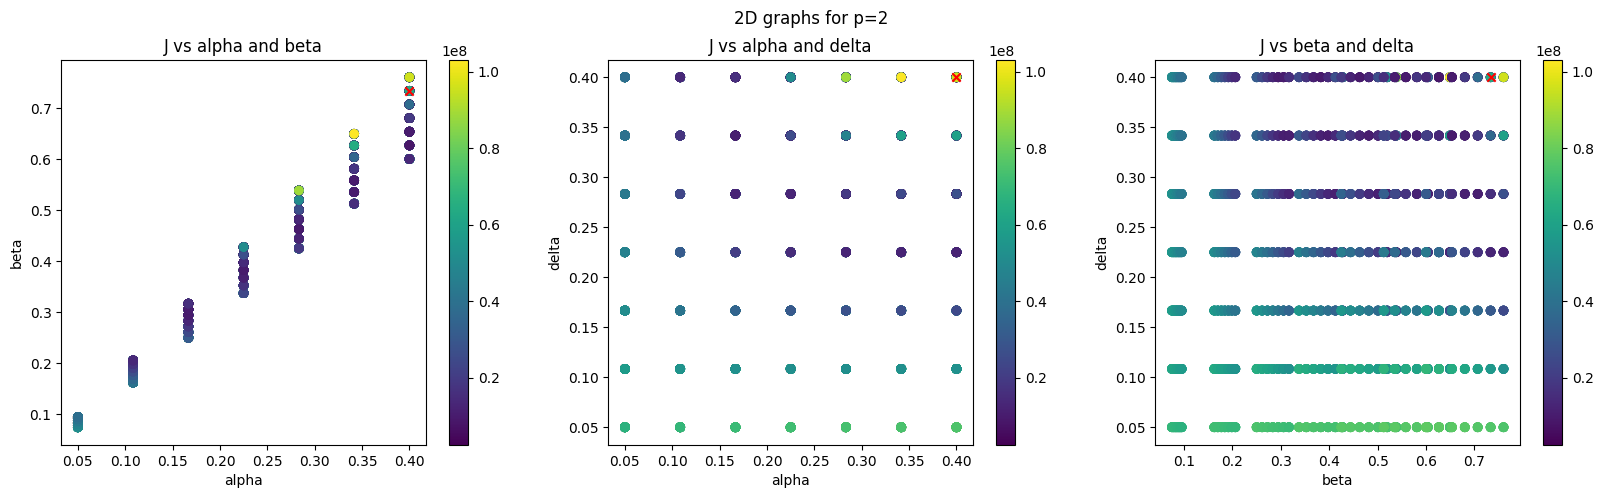

Time when I_sim is lower than 5: T=89


<Figure size 640x480 with 0 Axes>

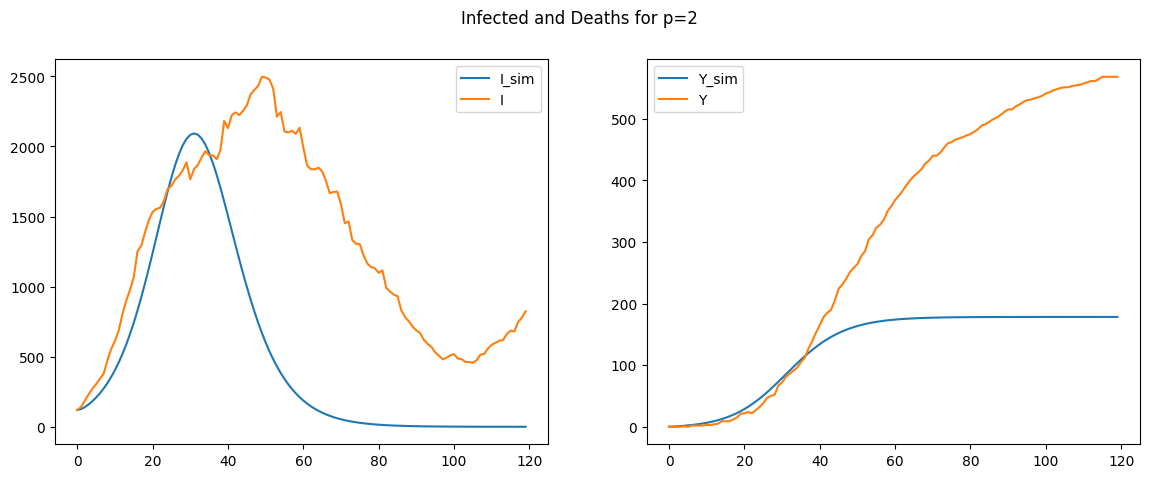

100%|██████████| 2401/2401 [00:20<00:00, 119.97it/s]

[p=inf] alpha: 0.3416666666666667, beta: 0.6263888888888889, delta: 0.4, r0: 1.8333333333333333, N: 32934.95333333334, gamma: 0.008556380006584806, J: 505.211090423393


<Figure size 640x480 with 0 Axes>

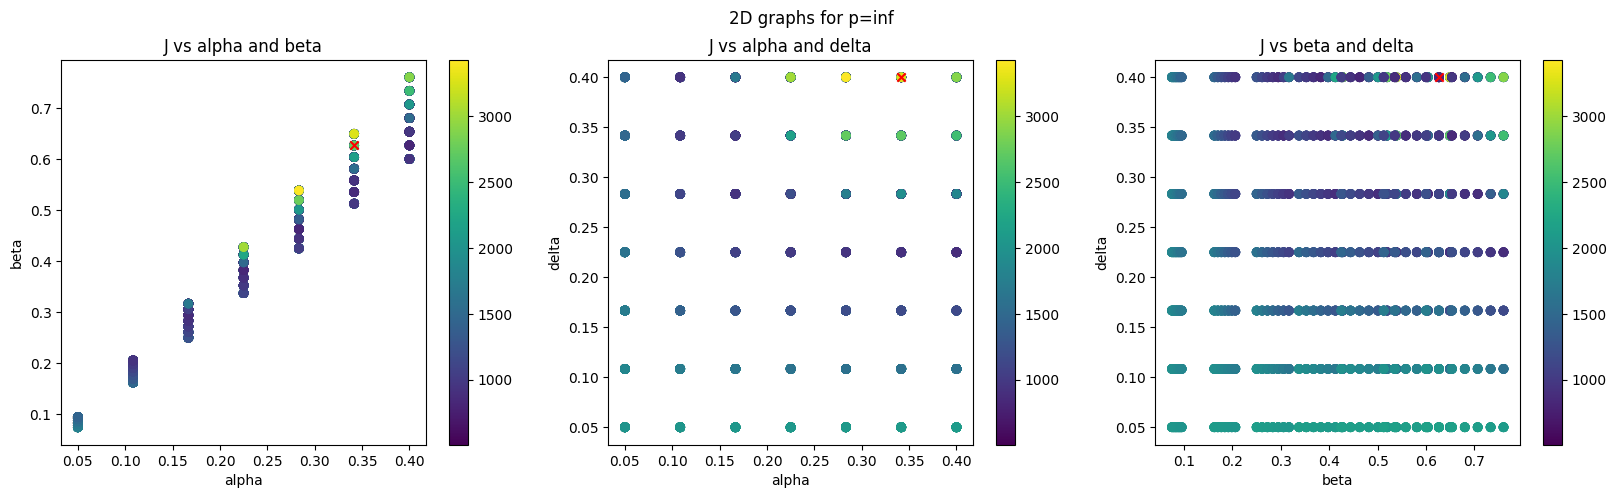

Time when I_sim is lower than 5: T=97


<Figure size 640x480 with 0 Axes>

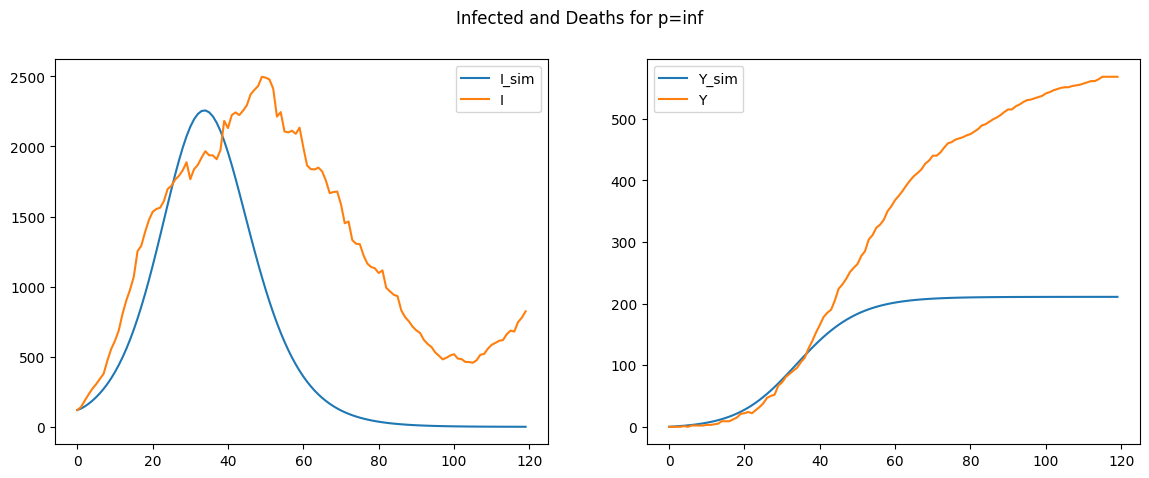

In [96]:
ps = [1, 2, np.inf]

for p in ps:
    lambda_ = 1
    minimum = None
    all_results = []

    for alpha, beta, delta, r0, N in tqdm(omegas):
        S_sim, E_sim, I_sim, R_sim = SEIR_simulation((alpha, beta, delta, N), T_max)
        gamma = get_gamma(R_sim[7:], p)

        if p != np.inf:
            J = np.sum(np.abs(I - I_sim) ** p) + lambda_ * np.sum(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim) ** p)
        else:
            J = np.max(np.abs(I - I_sim)) + lambda_ * np.max(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim))
            
        if minimum is None or J < minimum[0]:
            minimum = (J, alpha, beta, delta, r0, N, gamma)
        
        all_results.append((J, alpha, beta, delta, r0, N, gamma))

    J, alpha, beta, delta, r0, N, gamma = minimum
    all_results = np.array(all_results)

    print(f"[p={p}] alpha: {alpha}, beta: {beta}, delta: {delta}, r0: {r0}, N: {N}, gamma: {gamma}, J: {J}")

    # Sub Question (2)
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"2D graphs for p={p}")

    temp = ax1.scatter(all_results[:, 1], all_results[:, 2], c=all_results[:, 0])
    ax1.scatter(alpha, beta, c="red", marker="x")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("beta")
    ax1.set_title("J vs alpha and beta")
    fig.colorbar(temp, ax=ax1)

    temp = ax2.scatter(all_results[:, 1], all_results[:, 3], c=all_results[:, 0])
    ax2.scatter(alpha, delta, c="red", marker="x")
    ax2.set_xlabel("alpha")
    ax2.set_ylabel("delta")
    ax2.set_title("J vs alpha and delta")
    fig.colorbar(temp, ax=ax2)
    
    temp = ax3.scatter(all_results[:, 2], all_results[:, 3], c=all_results[:, 0])
    ax3.scatter(beta, delta, c="red", marker="x")
    ax3.set_xlabel("beta")
    ax3.set_ylabel("delta")
    ax3.set_title("J vs beta and delta")
    fig.colorbar(temp, ax=ax3)

    plt.show()

    # Sub Question (3)
    S_sim, E_sim, I_sim, R_sim = SEIR_simulation((alpha, beta, delta, N), 119)

    # Find when I_sim is lower than 5
    _, _, I_sim_long, _ = SEIR_simulation((alpha, beta, delta, N), 1000)
    pos = np.where(I_sim_long < 5)[0][0]
    print(f"Time when I_sim is lower than 5: T={pos}")

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(f"Infected and Deaths for p={p}")

    ax1.plot(I_sim, label="I_sim")
    ax1.plot(I_all, label="I")
    ax1.legend()

    ax2.plot(gamma * R_sim, label="Y_sim")
    ax2.plot(accumulated_deaths[:120], label="Y")
    ax2.legend()
    plt.show()
    

## Question (4)
If you are asked to improve the estimates, what would be your refined range of parameters?

The above data shows that the expected $\alpha$ is 0.05 (on the very left), while the expected $\beta$ is between 0.081 to 0.085, and the expected $\delta$ is between 0.03 to 0.045.

The $\delta$ is on the very top, so we probably need to improve the sampling range.  

We probably rerun the experiments with $\alpha \in [0.04, 0.075]$, $R0 \in [1.6, 1.75]$, and $\delta \in [0.35, 0.6]$.